In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import glob as gb
import cv2
import PIL
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau 
from keras.models import Sequential
from keras.layers import Conv2D , Dense , Dropout , Flatten , MaxPooling2D , BatchNormalization 
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow import keras
from keras.models import Model
import random
from sklearn.preprocessing import MinMaxScaler

In [2]:
import librosa.display
import IPython.display as ipd

In [3]:
path = 'ICBHI'


In [42]:
train = []
labels= []
train1=[]
files1=[]
for i in os.listdir(path):
    #entering train folder
    print("Entering to the folder name:",i)
    files=gb.glob(pathname=str(path+'/' + i + '/*.wav'))# pointing to all the .wav extension image folder
    print("Number of audio_files in the folder is",len(files))
    for j in files:
        # reading each audio file
        lung_sound ={'COPD':0,'Healthy':1 , 'Pneumonia' : 2}
        raw_data, sr = librosa.load(j,sr=None)
        train1.append(raw_data)
        train.append(raw_data)
        files1.append(j)
        labels.append(lung_sound[i])
        

Entering to the folder name: COPD
Number of audio_files in the folder is 94
Entering to the folder name: Healthy
Number of audio_files in the folder is 68
Entering to the folder name: Pneumonia
Number of audio_files in the folder is 74


In [44]:
train = np.array(train)
train1 = np.array(train1)
labels = np.array(labels)
type(train), train.shape, train1.shape
train1.shape


(236, 40000)

In [47]:
data = pd.DataFrame({
    "train" : list(train),
    "label" : labels
})
#data.drop(['train'] ,axis=1,inplace=True)
data = data.sample(frac=1 , random_state=236)
len(data)

236

In [48]:
train = np.array(data["train"])
labels = np.array(data["label"])
train[0] , labels[0]
#train.shape

(array([ 0.        ,  0.        ,  0.        , ..., -0.6773071 ,
        -0.6810913 , -0.68981934], dtype=float32),
 0)

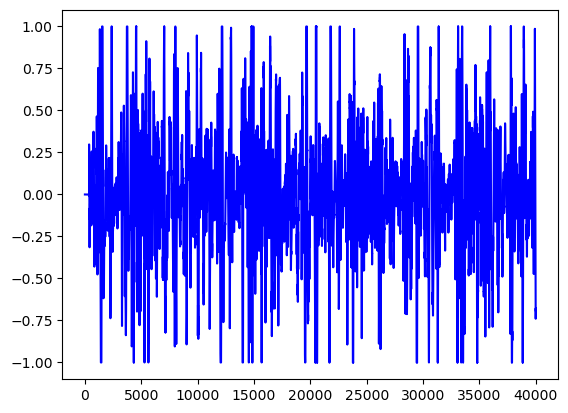

In [49]:
plt.plot(train[0], color="blue")

In [50]:

FRAME_SIZE = 1024
HOP_SIZE = 256
train_samples = []
test_samples = []

In [51]:
train_samples = []
for i in train:
    data = librosa.stft(i, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    train_samples.append(data)
    
train_samples = np.array(train_samples)
    

In [52]:
train_samples.shape, train_samples[0][0][0]

((236, 513, 157), (-0.20389971+0j))

In [53]:

type(train_samples[0][0][0])
train_scale = np.abs(train_samples)
train_scale.shape

(236, 513, 157)

In [54]:
train_scale[0][0][0], type(train_scale[0][0][0])

(0.20389971, numpy.float32)

In [55]:
def plot_spectrogram(Y, sr, hop_length, i, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

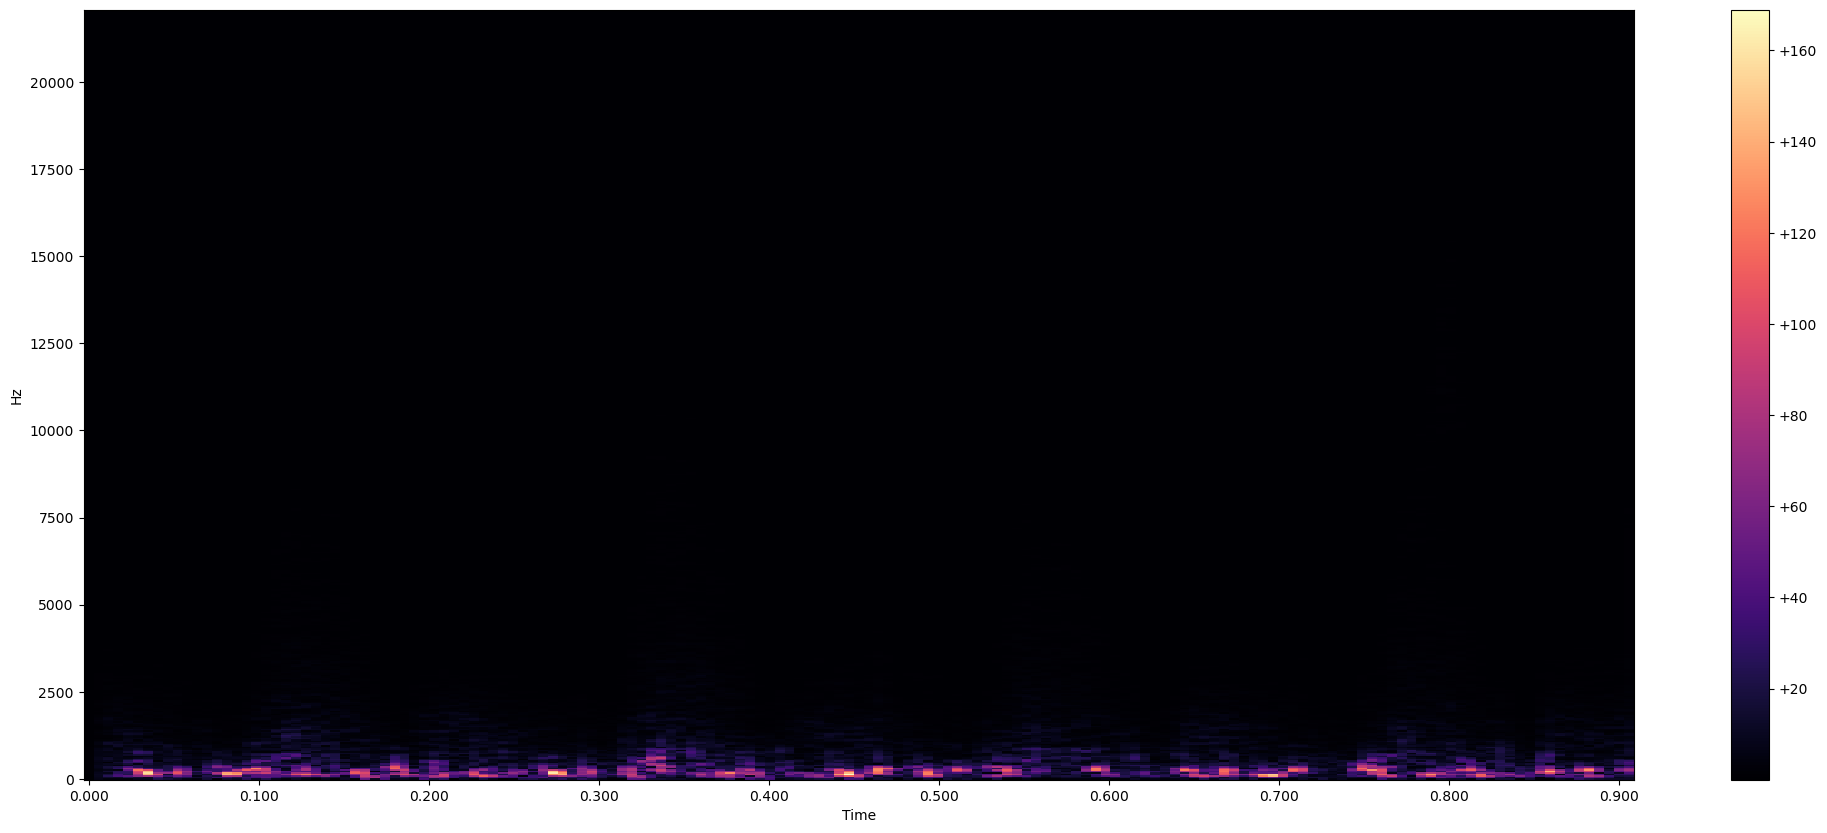

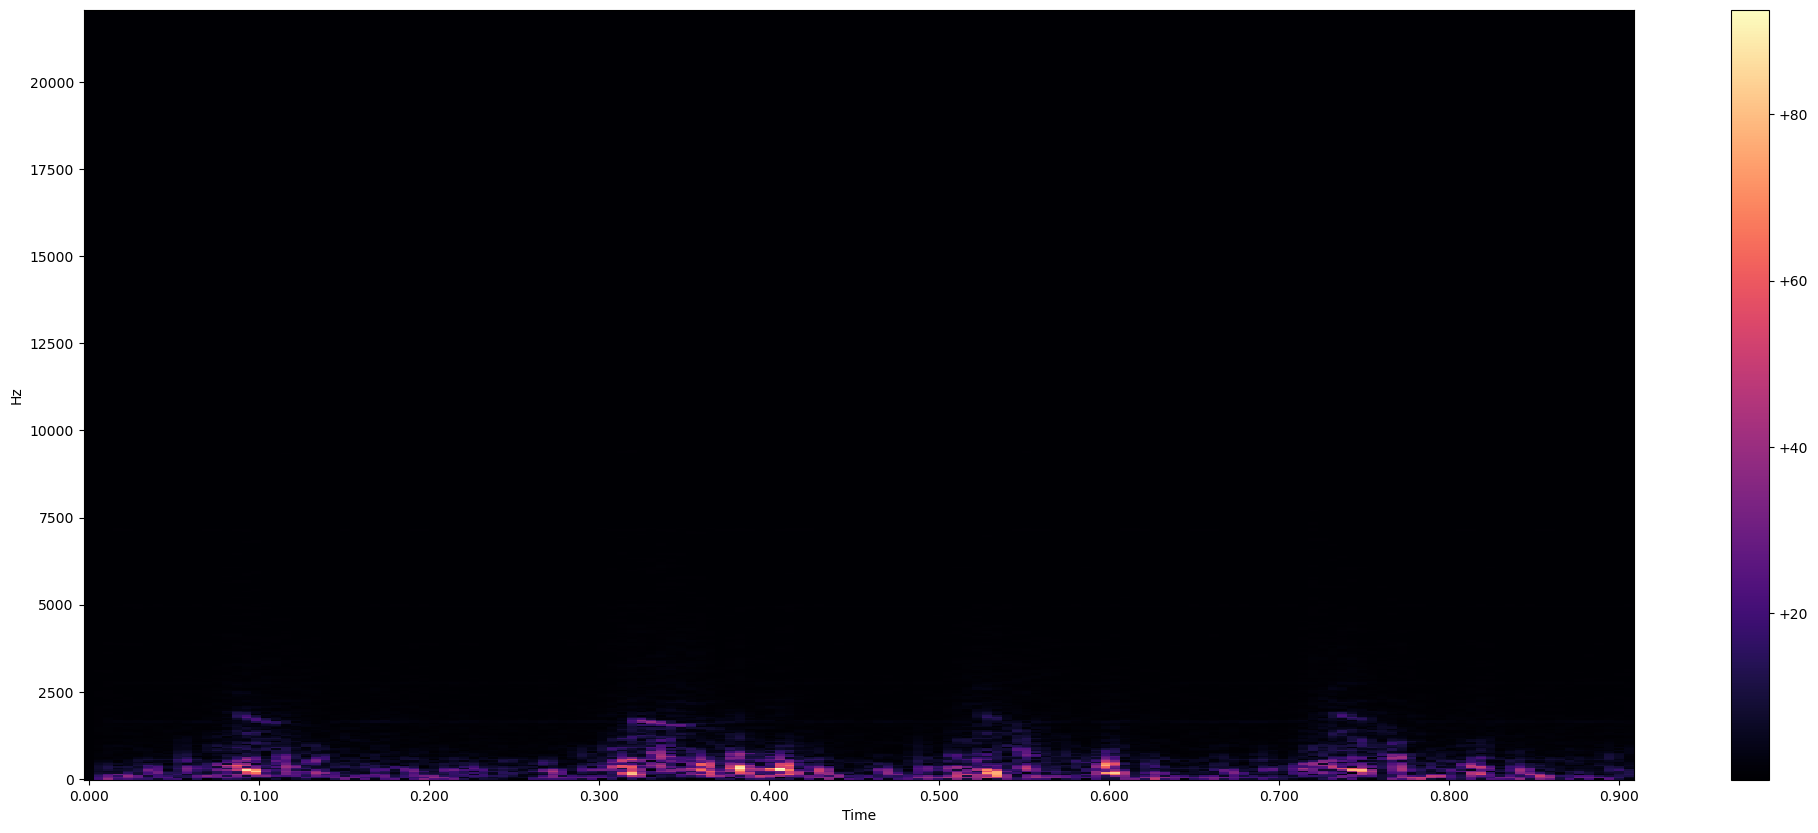

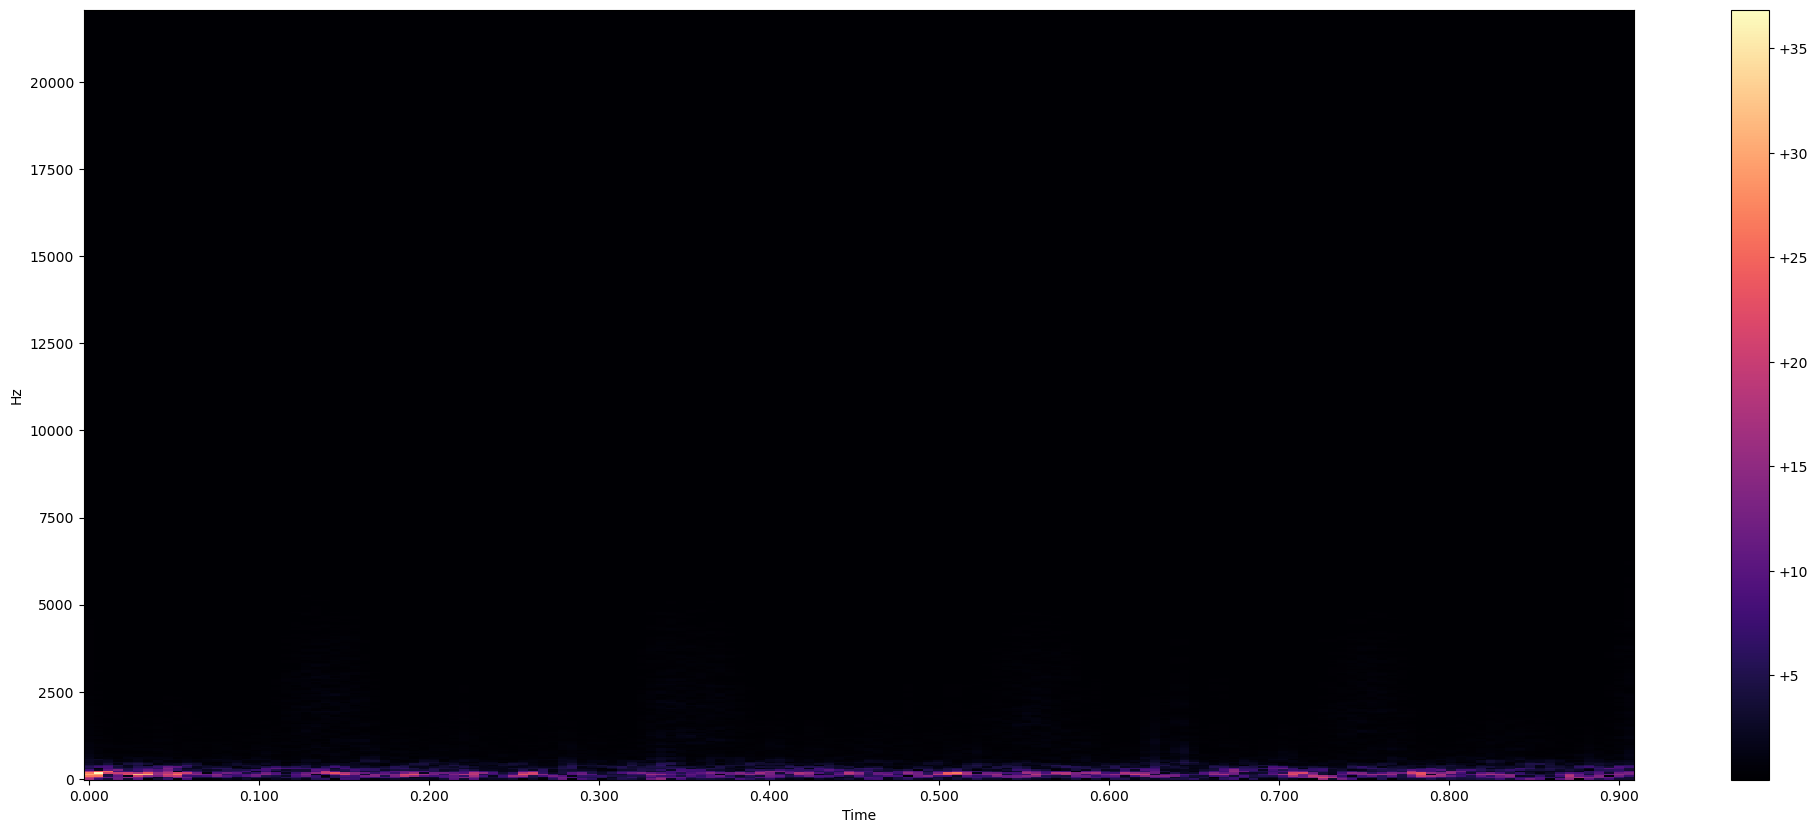

In [56]:
for i in range(3):
    plot_spectrogram(train_scale[i] , 44100, HOP_SIZE, i+1)

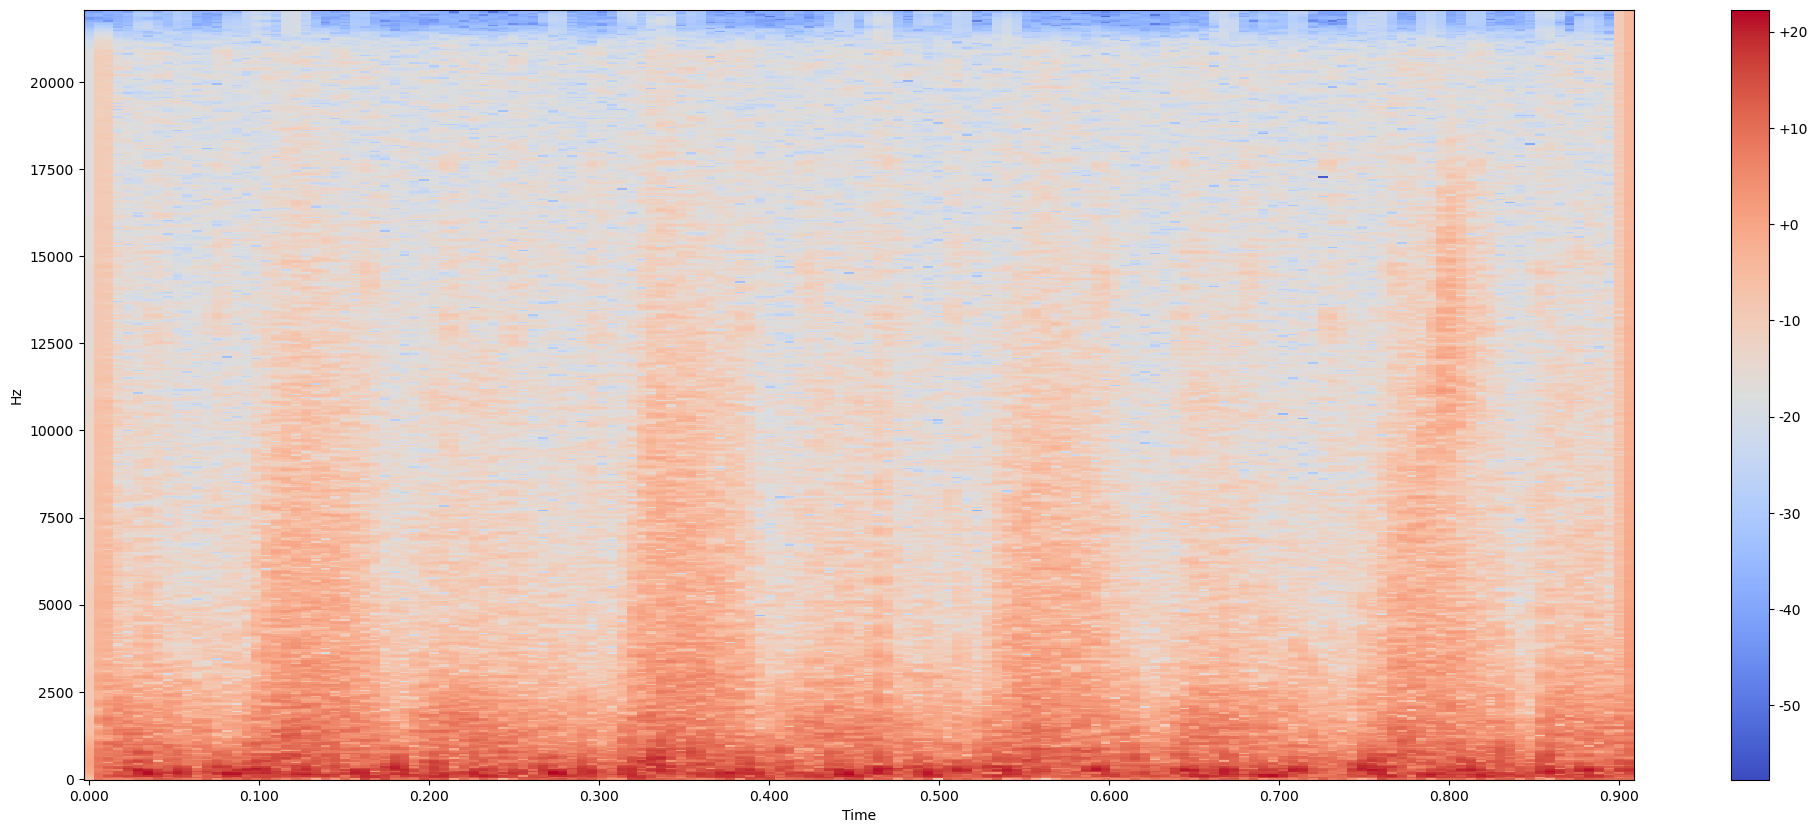

In [57]:
train_log = librosa.power_to_db(train_scale[0])
plot_spectrogram(train_log, 44100, HOP_SIZE, 0)

In [58]:
train_log[0][0], train_scale[0][0][0]

(-6.905834, 0.20389971)

In [124]:
X_train,  X_test, Y_train, Y_test = train_test_split(train_scale, labels, test_size=0.2,)

In [125]:
X_train.shape, Y_train.shape

((188, 513, 157), (188,))

In [126]:
scaler = MinMaxScaler()
x_train = []
x_test = []
for i in range(len(X_train)):
    t = scaler.fit_transform(X_train[i])
    x_train.append(t)
for i in range(len(X_test)):
    t = scaler.fit_transform(X_test[i])
    x_test.append(t)

x_train[0][0][0:10], Y_train[0:10]

(array([0.9999999 , 0.39566147, 0.5129283 , 0.20879237, 0.27666503,
        0.35658237, 0.2770779 , 0.33702305, 0.65979064, 0.68239045],
       dtype=float32),
 array([1, 0, 1, 2, 0, 0, 2, 1, 0, 0]))

In [127]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train.shape, Y_train.shape

((188, 513, 157), (188,))

In [128]:
x_train=x_train.reshape(-1,513, 157,1)
x_test = x_test.reshape(-1, 513, 157, 1)
x_train.shape , x_test.shape

((188, 513, 157, 1), (48, 513, 157, 1))

In [129]:
X_train=X_train.reshape(-1,513, 157,1)
X_test = X_test.reshape(-1, 513, 157, 1)
X_train.shape , X_test.shape

((188, 513, 157, 1), (48, 513, 157, 1))

In [130]:
def keras_to_categorical(y_train,y_test):
    return to_categorical(y_train),to_categorical(y_test)
 
Y_train, Y_test = keras_to_categorical(Y_train, Y_test)

In [131]:
Y_train[0]

array([0., 1., 0.])

Entering to Deep learning.

In [136]:
model = Sequential()

# Add convolutional layer with 32 3x3 filters, stride 2, and ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu',input_shape=(513,157,1)))

# Add max pooling layer with 2x2 kernel size and stride 1
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

# Add convolutional layer with 16 4x4 filters, stride 2, and ReLU activation
model.add(Conv2D(16, kernel_size=(4, 4), strides=(2, 2), activation='relu'))

# Add max pooling layer with 4x4 kernel size and stride 2
model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))

# Flatten the output
model.add(Flatten())

# Add fully connected layer with 8 neurons and ReLU activation
model.add(Dense(8, activation='relu'))

# Add fully connected layer with 10 neurons and softmax activation
model.add(Dense(3, activation='softmax'))

# Print model summary
model.summary()


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 256, 78, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 255, 77, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 126, 37, 16)    │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 62, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 16864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 8)              │       134,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,475 (560.45 KB)

 Trainable params: 143,475 (560.45 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
model.compile(optimizer="Adam",
 loss='categorical_crossentropy',
 metrics=['accuracy'])

model.fit(x_train, Y_train, epochs=5, verbose=1)
a,t= model.evaluate(x_test, Y_test, verbose= 0)
t


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.3910 - loss: 1.0782
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4281 - loss: 0.9795
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.4374 - loss: 0.9311
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5511 - loss: 0.8684
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.5811 - loss: 0.8832


0.6458333134651184